# Actividad Final

Selecciona un conjunto de datos que hayas utilizado en alguna de las prácticas desarrolladas.

En este caso usaremos el dateset de: https://data.world/exercises/principal-components-exercise-1

In [ ]:
# Importación de librerías 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.datasets import load_digits

from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch

from pylab import scatter, text, show, cm, figure
from pylab import subplot, imshow, NullLocator


import warnings
warnings.filterwarnings('ignore')

In [ ]:
# carga de datos
df = pd.read_csv('/content/nndb_flat.csv')
df.head(3)

,ID,FoodGroup,ShortDescrip,Descrip,CommonName,MfgName,ScientificName,Energy_kcal,Protein_g,Fat_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",NaN,NaN,NaN,717.0,0.85,81.11,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",NaN,NaN,NaN,876.0,0.28,99.48,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909


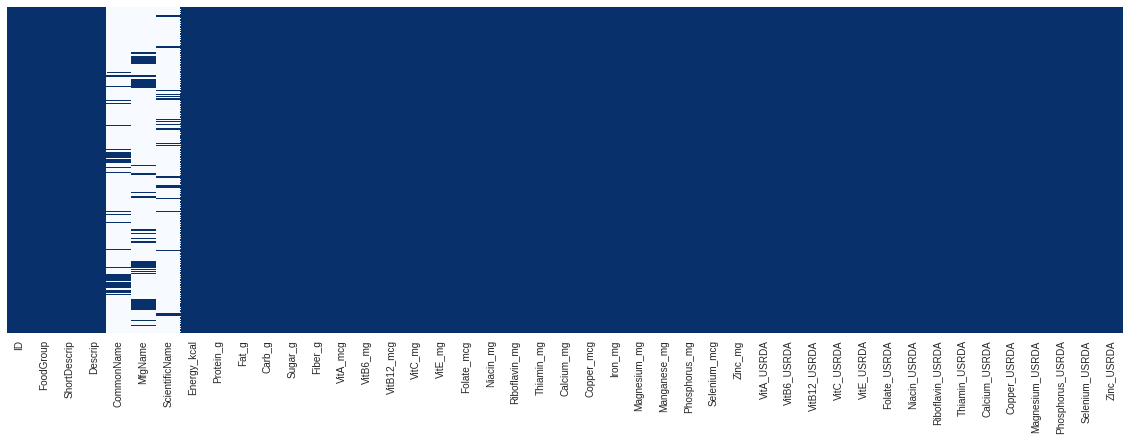

In [ ]:
# Visualización d datos nulos
plt.figure(figsize = (20, 6))
sns.heatmap(df.isnull(), annot = False, yticklabels = False, cbar = False, cmap = 'Blues_r')
plt.show()

In [ ]:
# Eliminación de columnas con valores nulos 
df.drop(['ID', 'CommonName', 'MfgName', 'ScientificName', 'ShortDescrip', 'Descrip'], axis = 1, inplace = True)

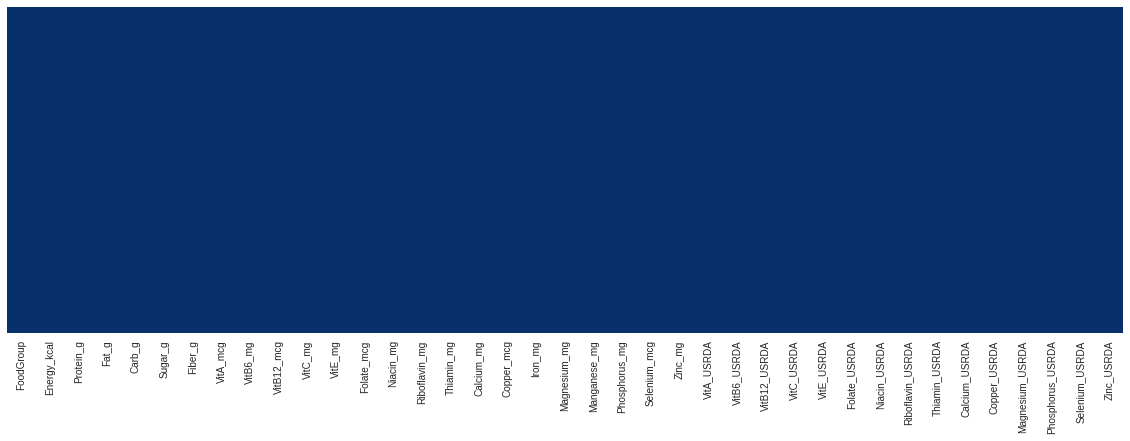

In [ ]:
# Visualización de datos nulos
plt.figure(figsize = (20, 6))
sns.heatmap(df.isnull(), annot = False, yticklabels = False, cbar = False, cmap = 'Blues_r')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 39 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   FoodGroup         8618 non-null   object 
 1   Energy_kcal       8618 non-null   float64
 2   Protein_g         8618 non-null   float64
 3   Fat_g             8618 non-null   float64
 4   Carb_g            8618 non-null   float64
 5   Sugar_g           8618 non-null   float64
 6   Fiber_g           8618 non-null   float64
 7   VitA_mcg          8618 non-null   float64
 8   VitB6_mg          8618 non-null   float64
 9   VitB12_mcg        8618 non-null   float64
 10  VitC_mg           8618 non-null   float64
 11  VitE_mg           8618 non-null   float64
 12  Folate_mcg        8618 non-null   float64
 13  Niacin_mg         8618 non-null   float64
 14  Riboflavin_mg     8618 non-null   float64
 15  Thiamin_mg        8618 non-null   float64
 16  Calcium_mg        8618 non-null   float64


In [ ]:
X = df.drop('FoodGroup', axis = 1).values # Features
y = df['FoodGroup'] # Variable target

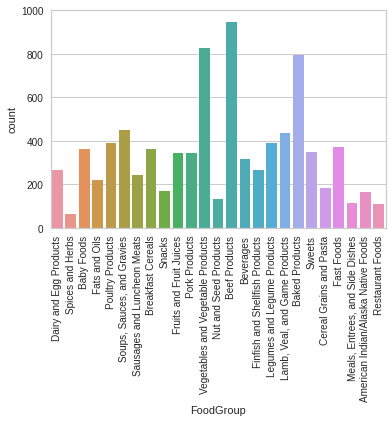

In [ ]:
# Visualización de la variable target
ax = sns.countplot(x = 'FoodGroup', data = df)
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylim(0, 1000)
plt.show()

Podemos observar una gran cantidad de categorías y un dataset desbalanceado.

## Ejercicio 1. Un algoritmo de agrupamiento de tu elección. Por ejemplo, un modelo de mezclas gaussianas o DBScan.

In [ ]:
X_sc = StandardScaler().fit_transform(X) # Estandarización de datos

En los algoritmos que usaremos elegiremos dividir al conjunto en $25$ para intentar clasificar los datos de acuerdo a la etiqueta *FoodGroup*.

In [ ]:
def predict_labels(modelo, X, y, todos = 'N'):
  '''
  Función que entrena el modelo y obtiene las predicciones de dicho modelo
  '''

  y_predict = modelo.fit_predict(X) # Entrenamiento y predicciones del modelo

  # Visualización de las categorías predichas por el modelo
  sns.countplot(x = y_predict)
  plt.title('Cantidad de elementos por categoría predicha')
  plt.xlabel('Label')
  plt.show()

  # Creación de un data frame con las categorías originales y las predichas
  predicciones = pd.DataFrame({
              'FoodGroup': y,            
              'labels': y_predict})
  
  # Impresión de todas las categorías predichas y las categorías reales que incluyen en caso de recibir el parametro todos = 'Y'
  if todos == 'Y':
    print('\nGrupos predichos:\n ')
    for i in range(25):
      print('label: {}, FoodGroups: {}'.format(i, list(predicciones[predicciones['labels'] == i]['FoodGroup'].unique())))

  # Impresión de las categorías predichas que contienen una sola categoría real (estas son consideradas categorías predichas correctamente)
  print('\nGrupos correctos:\n ')
  for i in range(25):

    lista =  list(predicciones[predicciones['labels'] == i]['FoodGroup'].unique()) # Obtenemos una lista de categorías reales incluidas en cada categoría predicha
    if len(lista) == 1:
      # Nos interesan las categorías predichas que contienen una única categoría real
      etiqueta_predicha = lista[0]

      # Creamos un dataframe que cuente cuantas veces aparece la etiqueta real en el conjunto de datos
      # y cuantas veces aparece la categoría predicha, esto servirá para comprobar las predicciones 
      y = pd.DataFrame(y)
      actual_count = y[y['FoodGroup'] == etiqueta_predicha].value_counts().to_frame().reset_index()[0][0]
      pred_count = predicciones[predicciones['labels'] == i].value_counts().to_frame().reset_index()[0][0]

      print('Etiqueta: {} - {} , Porcentaje {}'.format(i, etiqueta_predicha, round(pred_count/actual_count, 3 ) ))

      

### KMeans

De acuerdo a la gráfica se tiene que el número óptimo de grupos es $18$.

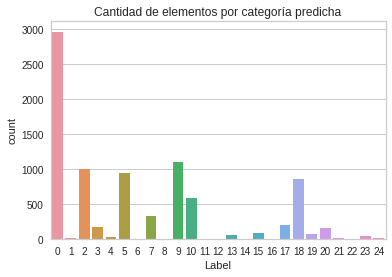


Grupos correctos:
 
Etiqueta: 8 - Baked Products , Porcentaje 0.003
Etiqueta: 11 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 12 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 14 - Breakfast Cereals , Porcentaje 0.011
Etiqueta: 16 - Beef Products , Porcentaje 0.002
Etiqueta: 22 - Beverages , Porcentaje 0.006
Etiqueta: 24 - Finfish and Shellfish Products , Porcentaje 0.022


In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_sc, y)

Este algoritmo predijo solo $7$ de los $25$ grupos de comida: *Nut and Seed Products*, *Baked Products*, *Beef Products*, *Vegetables and Vegetable Products*, *Beverages*, *Finfish and Selfish Products* y *Breakfast Cereals*.

### Gaussian Mixture

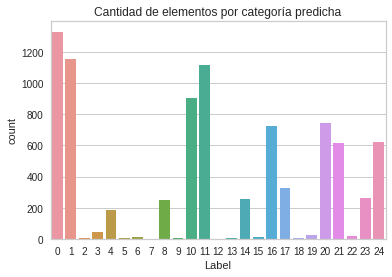


Grupos correctos:
 
Etiqueta: 2 - Lamb, Veal, and Game Products , Porcentaje 0.009
Etiqueta: 7 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 9 - Beef Products , Porcentaje 0.002
Etiqueta: 12 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 13 - Baked Products , Porcentaje 0.003
Etiqueta: 18 - Beverages , Porcentaje 0.006


In [ ]:
gaussian = GaussianMixture(n_components = 25, covariance_type = 'full', random_state = 42, max_iter = 200)
predict_labels(gaussian, X_sc, y)

En este algoritmo  predijo  $6$ de los $25$ grupos de comida: *Lamb, Veal, and Game Products*, *Nut and Seed Products*, *Baked Products*, *Beef Products*,*Vegetable and Vegetable Products* y *Beverages*

### Agglomerative

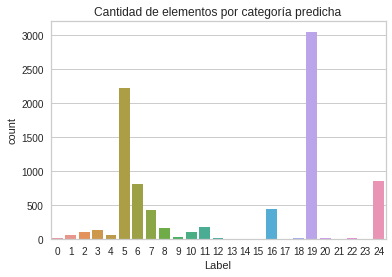


Grupos correctos:
 
Etiqueta: 13 - Beef Products , Porcentaje 0.002
Etiqueta: 14 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 15 - Baked Products , Porcentaje 0.003
Etiqueta: 17 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 18 - Finfish and Shellfish Products , Porcentaje 0.03
Etiqueta: 21 - Breakfast Cereals , Porcentaje 0.011
Etiqueta: 23 - Fats and Oils , Porcentaje 0.005


In [ ]:
agglomerative = AgglomerativeClustering(n_clusters = 25, affinity = 'euclidean', linkage = 'ward')
predict_labels(agglomerative, X_sc, y)

Este algoritmo predijo solo $7$ de los $25$ grupos de comida: *Nut and Seed Products*, *Baked Products*, *Beef Products*, *Vegetables and Vegetable Products*, *Fats and Oils*, *Finfish and Selfish Products* y *Breakfast Cereals*.

## Ejercicio 2. El análisis de componentes principales (PCA) para reducir su dimensión.

In [ ]:
# Matriz de covarianzas
cov_mat = np.cov(X_sc.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
len(eigen_vals)

38

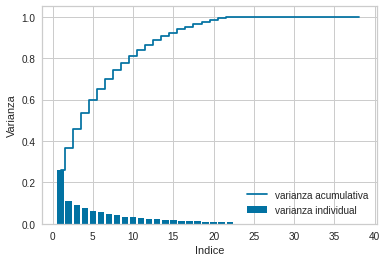

In [ ]:
tot = sum(eigen_vals)
var_exp = [ev / tot for ev in sorted(eigen_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)
plt.bar(range(1, 39), var_exp, label = 'varianza individual', align = 'center')
plt.step(range(1, 39), cum_var_exp, where = 'mid', label = 'varianza acumulativa')
plt.xlabel('Indice')
plt.ylabel('Varianza')
plt.legend(loc = 'best')
plt.show()

Podemos observar que cerca de 20 componentes contienen practicamente toda la información, por lo que se utilizará PCA con 20 componentes y se pondrán a prueba de nuevo los algoritmos de clustering.

In [ ]:
pca = PCA(n_components = 20)
X_sc_pca = pca.fit_transform(X_sc)

### KMeans

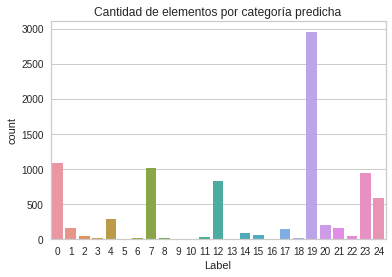


Grupos correctos:
 
Etiqueta: 5 - Beef Products , Porcentaje 0.002
Etiqueta: 9 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 10 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 13 - Baked Products , Porcentaje 0.004
Etiqueta: 16 - Breakfast Cereals , Porcentaje 0.011
Etiqueta: 18 - Finfish and Shellfish Products , Porcentaje 0.03


In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_sc_pca, y)

### Gaussian Mixture

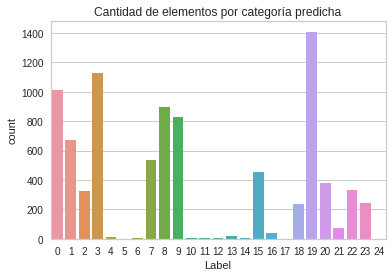


Grupos correctos:
 
Etiqueta: 5 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 10 - Baked Products , Porcentaje 0.004
Etiqueta: 14 - Breakfast Cereals , Porcentaje 0.011
Etiqueta: 17 - Beef Products , Porcentaje 0.002
Etiqueta: 24 - Nut and Seed Products , Porcentaje 0.008


In [ ]:
gaussian = GaussianMixture(n_components = 25, covariance_type = 'full', random_state = 42, max_iter = 200)
predict_labels(gaussian, X_sc_pca, y)

### Agglomerative

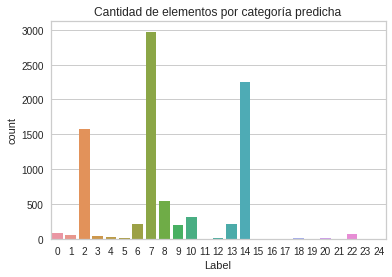


Grupos correctos:
 
Etiqueta: 15 - Beef Products , Porcentaje 0.002
Etiqueta: 16 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 17 - Baked Products , Porcentaje 0.003
Etiqueta: 18 - Finfish and Shellfish Products , Porcentaje 0.03
Etiqueta: 19 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 21 - Breakfast Cereals , Porcentaje 0.011
Etiqueta: 23 - Fats and Oils , Porcentaje 0.005
Etiqueta: 24 - Beverages , Porcentaje 0.006


In [ ]:
agglomerative = AgglomerativeClustering(n_clusters = 25, affinity = 'euclidean', linkage = 'ward')
predict_labels(agglomerative, X_sc_pca, y)

En general podemos observar que el porcentaje de predicciones se mantiene, por lo que el reducir las variables no afecta las predicciones. 

## Ejercicio 3. 

Un algoritmo para descubrir novedades y valores atípicos de tu elección.



Cantidad de outliers: 
  1    8531
-1      87
dtype: int64


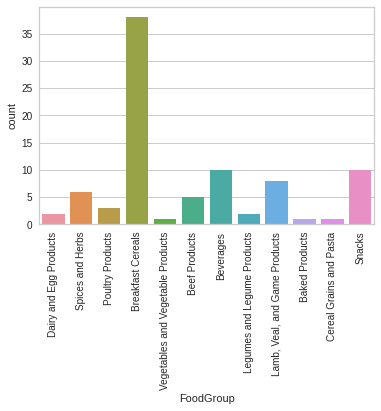

In [ ]:
model = IsolationForest(contamination = 0.01) # Se usará Isolation Forest 
outliers = model.fit_predict(X)
mask = outliers != -1
X_mask, y_mask = X[mask, :], y[mask]

print('Cantidad de outliers: \n', pd.DataFrame( outliers ).value_counts() ) # Imprimimos la cantidad de outliers (label = -1)

# Visualización de la cantidad de outliers por categoría 
ax = sns.countplot( y[outliers == -1] )
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.show()

Es interesante observar la gran cantidad de outliers detectados de una sola categoría *Breakfast Cereals*, por lo que esto puede hacernos sospechar que no se consideraron adecuadamente las características de la tabla para clasificar las categorías de la misma.

In [ ]:
X_mask_sc = StandardScaler().fit_transform(X_mask)

In [ ]:
# Volvemos a reducir componentes, debido a que esto no afecta las predicciones 
pca = PCA(n_components = 20, random_state = 42)
X_mask_sc_pca = pca.fit_transform(X_mask_sc)

### KMeans

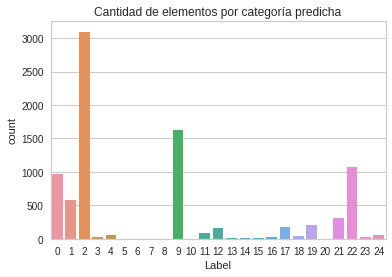


Grupos correctos:
 
Etiqueta: 4 - Breakfast Cereals , Porcentaje 0.175
Etiqueta: 5 - Baked Products , Porcentaje 0.003
Etiqueta: 7 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 8 - Fats and Oils , Porcentaje 0.005
Etiqueta: 10 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 14 - Finfish and Shellfish Products , Porcentaje 0.026
Etiqueta: 20 - Fats and Oils , Porcentaje 0.005


In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_mask_sc_pca, y_mask)

 
Se puede notar una mejora considerable en el porcentaje de predicciones de la categoría *Breakfast Cereals* que de hecho es de la categoría de la cual se detectaron más outliers. Otras como *Nut and Seed Products*, *Vegetables and Vegetable Products*, *Baked Products* se mantuvieron. Por otro lado el algoritmo, al eliminar los outliers logró detectar más categorias.


### Gaussian Mixture

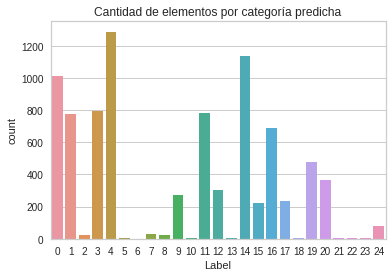


Grupos correctos:
 
Etiqueta: 6 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 10 - Baked Products , Porcentaje 0.003
Etiqueta: 21 - Beverages , Porcentaje 0.007
Etiqueta: 22 - Finfish and Shellfish Products , Porcentaje 0.015


In [ ]:
gaussian = GaussianMixture(n_components = 25, covariance_type = 'full', random_state = 42, max_iter = 200)
predict_labels(gaussian, X_mask_sc_pca, y_mask)

Hubo una ligera mejora en la etiqueta *Baked Products* y la categoria *Vegetables and Vegetable Products* se mantuvo con el mismo valor.
Por otro lado, se detectaron dos categorías nuevas no predichas antes y con un mejor pocentaje.

### Agglomerative

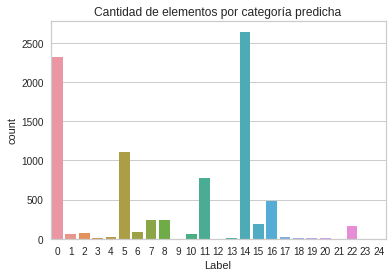


Grupos correctos:
 
Etiqueta: 9 - Baked Products , Porcentaje 0.003
Etiqueta: 12 - Vegetables and Vegetable Products , Porcentaje 0.001
Etiqueta: 13 - Finfish and Shellfish Products , Porcentaje 0.03
Etiqueta: 20 - Legumes and Legume Products , Porcentaje 0.01
Etiqueta: 21 - Nut and Seed Products , Porcentaje 0.008
Etiqueta: 23 - Fats and Oils , Porcentaje 0.005
Etiqueta: 24 - Fats and Oils , Porcentaje 0.005


In [ ]:
agglomerative = AgglomerativeClustering(n_clusters = 25, affinity = 'euclidean', linkage = 'ward')
predict_labels(agglomerative, X_mask_sc_pca, y_mask)

Practicamente los porcentajes de predicciones se mantuvieron en todos los casos, sin embargo, podemos notar algo bastante interesante, este algoritmo predijo como dos categorias diferentes lo que de acuerdo a los datos deberían ser una sola categoría *Fats and Oils*. Esto puede significar que dichas categorías no fueron tomadas considerando las características propias de los datos existentes en la tabla si no el criterio de las personas encargadas del llenado de la tabla.


## Ejercicio 4.

El método KernelPCA.

El algoritmo que mejores predicciones ha hecho es KMeans por lo que a partir de este punto, trabajaremos con este algoritmo.

### Sin algoritmo  de detección de outliers.

In [ ]:
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 30)
X_sc_kpca = kpca.fit_transform(X_sc)

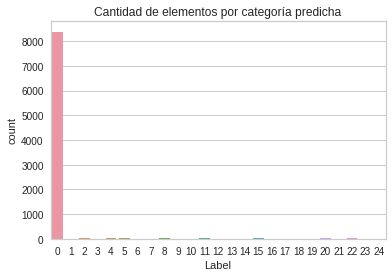


Grupos predichos:
 
label: 0, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies', 'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks', 'Fruits and Fruit Juices', 'Pork Products', 'Vegetables and Vegetable Products', 'Nut and Seed Products', 'Beef Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Products', 'Lamb, Veal, and Game Products', 'Baked Products', 'Sweets', 'Cereal Grains and Pasta', 'Fast Foods', 'Meals, Entrees, and Side Dishes', 'American Indian/Alaska Native Foods', 'Restaurant Foods']
label: 1, FoodGroups: ['Soups, Sauces, and Gravies', 'Beverages']
label: 2, FoodGroups: ['Beverages']
label: 3, FoodGroups: ['Soups, Sauces, and Gravies', 'Beverages']
label: 4, FoodGroups: ['Soups, Sauces, and Gravies']
label: 5, FoodGroups: ['Spices and Herbs', 'Soups, Sauces, and Gravies', 'Beverages', 'Baked Products', 'American Indian/Alaska Native Foods']
label:

In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_sc_kpca, y, 'Y')

En este caso podemos observar que la etiqueta 0, predicha por el algoritmo, contiene practicamente todas las categorías, lo que significa que las características de estas etiquetas son realmente muy parecidas, lo que puede explicar el por que no se han podido predecir si no, a lo más $7$ de las $25$ etiquetas originales.

In [ ]:
labels = list(y.to_frame()['FoodGroup'].unique())

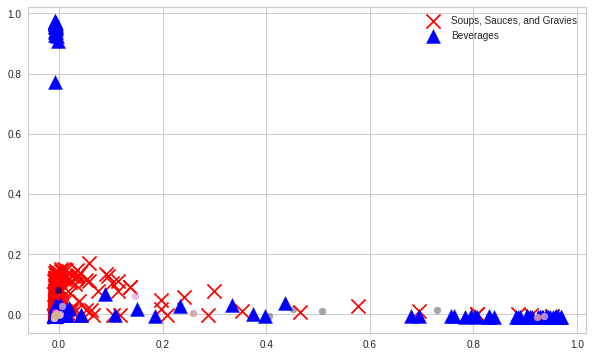

In [ ]:
colors = ['black', 'grey', 'rosybrown', 'lightcoral', 'red', 
          'tomato', 'saddlebrown', 'olive', 'darkseagreen', 'forestgreen',
          'springgreen', 'turquoise', 'darkslategray', 'cyan', 'steelblue',
          'royalblue', 'navy', 'slateblue', 'indigo', 'plum',
          'purple','y', 'fuchsia', 'pink', 'tan']
plt.figure(figsize = (10, 6))
for i, label in enumerate(labels):
  if label == 'Soups, Sauces, and Gravies':
    plt.scatter(X_sc_kpca[y == label, 0], X_sc_kpca[y == label, 1], color = 'red', marker = 'x', s = 200, label = 'Soups, Sauces, and Gravies' )
  elif label == 'Beverages':
    plt.scatter(X_sc_kpca[y == label, 0], X_sc_kpca[y == label, 1], color = 'blue', marker = '^', s = 200, label = 'Beverages' )
  else:
    plt.scatter(X_sc_kpca[y == label, 0], X_sc_kpca[y == label, 1], color = colors[i], marker = 'o', alpha = 0.7)
plt.legend()
plt.show()

Podemos observar que un subconjunto de la categoría *Beverages* el algoritmo logró separarla bien (los que se encuentran en la parte superior), por otro lado las dos etiquetas predichas se localizan practicamente a lo largo del eje X, mientras que el resto de puntos pareciera localizarse aglomerado cerca del origen, lo que significa que tienen características muy similares lo que explicaría la dificultad de predecirlas.

### Algoritmo con detección de outliers.




In [ ]:
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 30)
X_mask_sc_kpca = kpca.fit_transform(X_mask_sc)

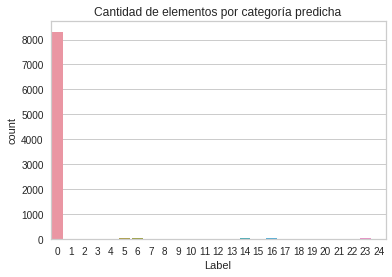


Grupos predichos:
 
label: 0, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies', 'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Snacks', 'Fruits and Fruit Juices', 'Pork Products', 'Vegetables and Vegetable Products', 'Nut and Seed Products', 'Beef Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Products', 'Lamb, Veal, and Game Products', 'Baked Products', 'Sweets', 'Cereal Grains and Pasta', 'Fast Foods', 'Meals, Entrees, and Side Dishes', 'American Indian/Alaska Native Foods', 'Restaurant Foods']
label: 1, FoodGroups: ['Soups, Sauces, and Gravies', 'Beverages']
label: 2, FoodGroups: ['Beverages']
label: 3, FoodGroups: ['Spices and Herbs', 'Beverages']
label: 4, FoodGroups: ['Soups, Sauces, and Gravies', 'Beverages']
label: 5, FoodGroups: ['Spices and Herbs', 'Soups, Sauces, and Gravies', 'Beverages', 'Baked Products']
label: 6, FoodGroups: ['Soups, Sauces, and

In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_mask_sc_kpca, y_mask, 'Y')

En este caso observamos lo mismo una categoría predicha contiene casi todos los puntos del dataset. Sin embargo a pesar de ello hubo una mejora en los porcentajes predichos de la categoría  *Beverages* aunque se disminuyeron los porcentajes de *Soups, Sauces, and Gravies* .

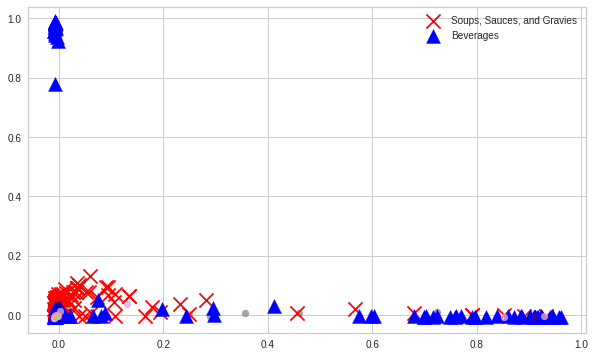

In [ ]:
colors = ['black', 'grey', 'rosybrown', 'lightcoral', 'red', 
          'tomato', 'saddlebrown', 'olive', 'darkseagreen', 'forestgreen',
          'springgreen', 'turquoise', 'darkslategray', 'cyan', 'steelblue',
          'royalblue', 'navy', 'slateblue', 'indigo', 'plum',
          'purple','y', 'fuchsia', 'pink', 'tan']
plt.figure(figsize = (10, 6))
for i, label in enumerate(labels):
  if label == 'Soups, Sauces, and Gravies':
    plt.scatter(X_mask_sc_kpca[y_mask == label, 0], X_mask_sc_kpca[y_mask == label, 1], color = 'red', marker = 'x', s = 200, label = 'Soups, Sauces, and Gravies' )
  elif label == 'Beverages':
    plt.scatter(X_mask_sc_kpca[y_mask == label, 0], X_mask_sc_kpca[y_mask == label, 1], color = 'blue', marker = '^', s = 200, label = 'Beverages' )
  else:
    plt.scatter(X_mask_sc_kpca[y_mask == label, 0], X_mask_sc_kpca[y_mask == label, 1], color = colors[i], marker = 'o', alpha = 0.7)
plt.legend()
plt.show()

En este caso una notable mejora en los porcentajes de las etiquetas predichas correctamente para *Beverages*. Y esto es algo que podemos apreciar en la gráfica pues es notable que ambas categorías parecen pegarse al eje X aún más que en el caso anterior, sobre todo, en el caso de *Beverages*. De hecho en el caso de la otra categorá los puntos se agruparon más hacia el origen, lo que explica la disminución de los porcentajes. 

## Ejercicio 5.

Una técnica de Manifold Learning para reducir su dimensionalidad.

## Sin detección de outliers

In [ ]:
manifold = LocallyLinearEmbedding(n_neighbors = 10, n_components = 2, random_state = 42)
X_sc_manifold = manifold.fit_transform(X_sc)

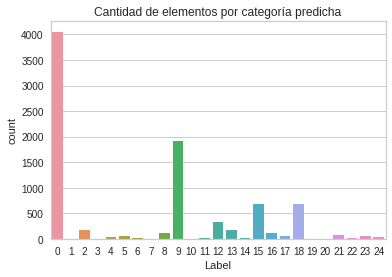


Grupos predichos:
 
label: 0, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies', 'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Fruits and Fruit Juices', 'Pork Products', 'Vegetables and Vegetable Products', 'Nut and Seed Products', 'Beef Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Products', 'Lamb, Veal, and Game Products', 'Baked Products', 'Snacks', 'Sweets', 'Cereal Grains and Pasta', 'Fast Foods', 'Meals, Entrees, and Side Dishes', 'American Indian/Alaska Native Foods', 'Restaurant Foods']
label: 1, FoodGroups: ['Finfish and Shellfish Products']
label: 2, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Poultry Products', 'Soups, Sauces, and Gravies', 'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Vegetables and Vegetable Products', 'Beef Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Product

In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_sc_manifold, y, 'Y')

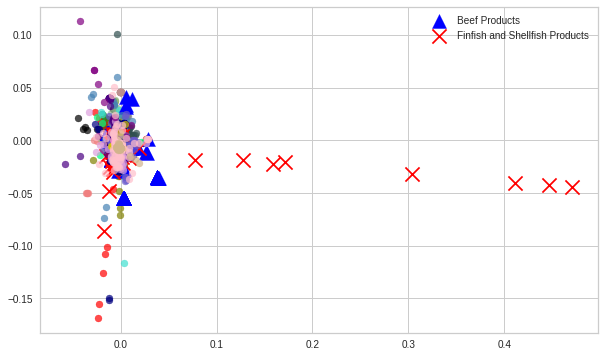

In [ ]:
colors = ['black', 'grey', 'rosybrown', 'lightcoral', 'red', 
          'tomato', 'saddlebrown', 'olive', 'darkseagreen', 'forestgreen',
          'springgreen', 'turquoise', 'darkslategray', 'cyan', 'steelblue',
          'royalblue', 'navy', 'slateblue', 'indigo', 'plum',
          'purple','y', 'fuchsia', 'pink', 'tan']
plt.figure(figsize = (10, 6))
for i, label in enumerate(labels):
  if label == 'Finfish and Shellfish Products':
    plt.scatter(X_sc_manifold[y == label, 0], X_sc_manifold[y == label, 1], color = 'red', marker = 'x', s = 200, label = 'Finfish and Shellfish Products' )
  elif label == 'Beef Products':
    plt.scatter(X_sc_manifold[y == label, 0], X_sc_manifold[y == label, 1], color = 'blue', marker = '^', s = 200, label = 'Beef Products' )
  else:
    plt.scatter(X_sc_manifold[y == label, 0], X_sc_manifold[y == label, 1], color = colors[i], marker = 'o', alpha = 0.7)
plt.legend()
plt.show()

Este algoritmo solo logró detectar una de las $25$ categorías, sin embargo, parece que la categoría *Finfish and Shellfish Products* logró separarla mas o menos bien del resto, lo que explica el porcentaje de datos predichos dentro de esta categoría.

### Algoritmo con detección de outliers.


In [ ]:
manifold = LocallyLinearEmbedding(n_neighbors = 10, n_components = 2, random_state = 42)
X_mask_sc_manifold = manifold.fit_transform(X_mask_sc)

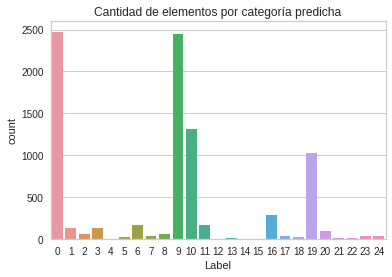


Grupos predichos:
 
label: 0, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Fats and Oils', 'Poultry Products', 'Soups, Sauces, and Gravies', 'Sausages and Luncheon Meats', 'Breakfast Cereals', 'Fruits and Fruit Juices', 'Pork Products', 'Vegetables and Vegetable Products', 'Nut and Seed Products', 'Beef Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Products', 'Lamb, Veal, and Game Products', 'Baked Products', 'Snacks', 'Sweets', 'Cereal Grains and Pasta', 'Fast Foods', 'Meals, Entrees, and Side Dishes', 'American Indian/Alaska Native Foods', 'Restaurant Foods']
label: 1, FoodGroups: ['Dairy and Egg Products', 'Spices and Herbs', 'Baby Foods', 'Fats and Oils', 'Poultry Products', 'Breakfast Cereals', 'Fruits and Fruit Juices', 'Vegetables and Vegetable Products', 'Beverages', 'Finfish and Shellfish Products', 'Legumes and Legume Products', 'Lamb, Veal, and Game Products', 'Baked Products', 'Snacks', 'Sweets', 'Fast Foods', 'B

In [ ]:
kmeans = KMeans(n_clusters = 25, random_state = 42)
predict_labels(kmeans, X_mask_sc_manifold, y_mask, 'Y')

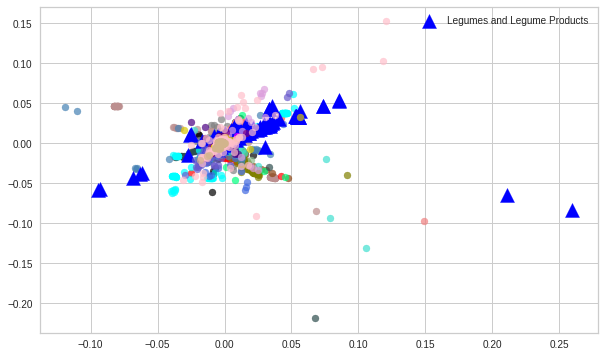

In [ ]:
colors = ['black', 'grey', 'rosybrown', 'lightcoral', 'red', 
          'tomato', 'saddlebrown', 'olive', 'darkseagreen', 'forestgreen',
          'springgreen', 'turquoise', 'darkslategray', 'cyan', 'steelblue',
          'royalblue', 'navy', 'slateblue', 'indigo', 'plum',
          'purple','y', 'fuchsia', 'pink', 'tan']
plt.figure(figsize = (10, 6))
for i, label in enumerate(labels):
  if label == 'American Indian/Alaska Native':
    plt.scatter(X_mask_sc_manifold[y_mask == label, 0], X_mask_sc_manifold[y_mask == label, 1], color = 'red', marker = 'x', s = 200, label = 'American Indian/Alaska Native' )
  elif label == 'Legumes and Legume Products':
    plt.scatter(X_mask_sc_manifold[y_mask == label, 0], X_mask_sc_manifold[y_mask == label, 1], color = 'blue', marker = '^', s = 200, label = 'Legumes and Legume Products' )
  else:
    plt.scatter(X_mask_sc_manifold[y_mask == label, 0], X_mask_sc_manifold[y_mask == label, 1], color = colors[i], marker = 'o', alpha = 0.7)
plt.legend()
plt.show()

En este caso aumentó el número de categorías predichas, pero los porcentajes no son muy altos, sin embargo, es interesante ver en la gráfica que todos los puntos tanto en este algoritmo como en kernel PCA,parecieran aglomerarse en un punto. Esto puede significar la existencia de una especie de singularidad debida a lo parecido de los datos entre las categorías esto explicaría la dificultad de predecir de clasificar los puntos correctamente de acuerdo a las etiquetas provenientes de los datos. 